In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wfp-food-prices-niger/wfp_food_prices_niger.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from datetime import datetime

In [3]:
df_ner = pd.read_csv('../input/wfp-food-prices-niger/wfp_food_prices_niger.csv')
df_ner.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,1/15/1990,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Millet,KG,actual,Retail,XOF,63.0,0.0965
1,1/15/1990,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
2,1/15/1990,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Sorghum,KG,actual,Retail,XOF,56.0,0.0857
3,1/15/1990,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Millet,KG,actual,Retail,XOF,73.0,0.1118
4,1/15/1990,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062


# Data Exploration

In [4]:
df_ner.shape

(57606, 14)

In [5]:
df_ner.isna().sum()

date         0
admin1       0
admin2       0
market       0
latitude     0
longitude    0
category     0
commodity    0
unit         0
priceflag    0
pricetype    0
currency     0
price        0
usdprice     0
dtype: int64

In [6]:
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57606 entries, 0 to 57605
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       57606 non-null  object 
 1   admin1     57606 non-null  object 
 2   admin2     57606 non-null  object 
 3   market     57606 non-null  object 
 4   latitude   57606 non-null  float64
 5   longitude  57606 non-null  float64
 6   category   57606 non-null  object 
 7   commodity  57606 non-null  object 
 8   unit       57606 non-null  object 
 9   priceflag  57606 non-null  object 
 10  pricetype  57606 non-null  object 
 11  currency   57606 non-null  object 
 12  price      57606 non-null  float64
 13  usdprice   57606 non-null  float64
dtypes: float64(4), object(10)
memory usage: 6.2+ MB


In [7]:
# convert date str to datetime format
df_ner['date'] = df_ner['date'].apply(str) 
df_ner['date'] = pd.to_datetime(df_ner['date'], infer_datetime_format=True)

<AxesSubplot:xlabel='price', ylabel='Density'>

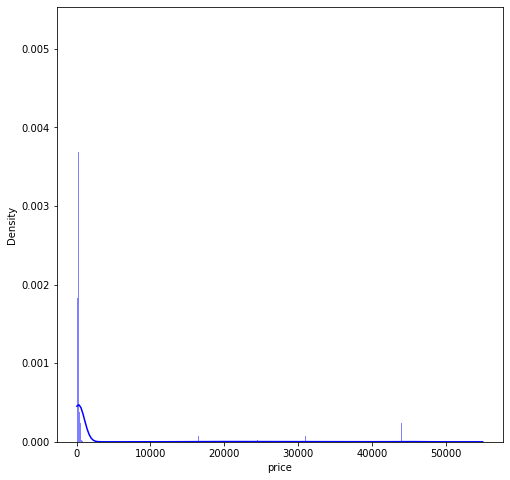

In [8]:
plt.figure(figsize=(8,8))
sns.histplot(df_ner["price"], color='blue', label="cols", kde=True, stat="density", linewidth=0)

it seem that we have outliers in our dataset, let us check it

In [9]:
min_threshold,max_threshold = df_ner["price"].quantile([0.05,0.95])
min_threshold,max_threshold

(108.0, 17000.0)

In [10]:
df_ner[df_ner["price"]<max_threshold]

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,1990-01-15,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Millet,KG,actual,Retail,XOF,63.0,0.0965
1,1990-01-15,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
2,1990-01-15,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Sorghum,KG,actual,Retail,XOF,56.0,0.0857
3,1990-01-15,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Millet,KG,actual,Retail,XOF,73.0,0.1118
4,1990-01-15,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57601,2022-07-15,Zinder,Takieta,Magaria,13.842343,8.520289,cereals and tubers,Sorghum,KG,actual,Retail,XOF,261.0,0.3996
57602,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Maize,KG,actual,Retail,XOF,325.0,0.4976
57603,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Millet,KG,actual,Retail,XOF,311.0,0.4761
57604,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,510.0,0.7808


In [11]:
df_ner[df_ner["price"]>min_threshold]

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
1,1990-01-15,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
4,1990-01-15,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
6,1990-01-15,Maradi,Madarounfa,Maradi Commune,13.500000,7.101744,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,205.0,0.3139
13,1990-02-15,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
16,1990-02-15,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,200.0,0.3062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57601,2022-07-15,Zinder,Takieta,Magaria,13.842343,8.520289,cereals and tubers,Sorghum,KG,actual,Retail,XOF,261.0,0.3996
57602,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Maize,KG,actual,Retail,XOF,325.0,0.4976
57603,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Millet,KG,actual,Retail,XOF,311.0,0.4761
57604,2022-07-15,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,510.0,0.7808


In [12]:
df_ner_eq = df_ner[(df_ner.price<max_threshold)& (df_ner.price>min_threshold)]
df_ner_eq.shape

(51698, 14)

let's check if we still have outliers

In [13]:
df_ner_eq.sample(10)

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
54054,2021-04-15,Agadez,Arlit,Arlit,18.736944,7.385278,cereals and tubers,Millet,KG,actual,Retail,XOF,296.00,0.4532
41381,2016-10-15,Zinder,Kantché,Matameye,13.423087,8.474850,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,500.00,0.7655
21868,2010-09-15,Tahoua,Tchintabara,Nguel Kolo,15.410000,5.720000,pulses and nuts,Beans (niebe),KG,actual,Retail,XOF,337.88,0.5173
33819,2014-04-15,Maradi,Guidan Roumji,Sabon Machi,13.871593,6.974098,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,537.50,0.8229
20916,2010-06-15,Zinder,Dungass,Dungass,13.061534,9.343423,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,475.00,0.7272
22125,2010-10-15,Niamey,Niamey,Petit Marche,13.516667,2.116667,cereals and tubers,Millet,KG,actual,Retail,XOF,198.41,0.3038
13747,2008-03-15,Zinder,Kantché,Matameye,13.423087,8.474850,cereals and tubers,Millet,KG,actual,Retail,XOF,162.00,0.2480
33499,2014-03-15,Diffa,Diffa,Diffa Commune,13.315360,12.611345,cereals and tubers,Millet,KG,actual,Retail,XOF,269.30,0.4123
31945,2013-10-15,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,actual,Retail,XOF,450.00,0.6890
23003,2011-01-15,Maradi,Guidan Roumji,Guidan Roumdji,13.657597,6.695675,cereals and tubers,Maize,KG,actual,Retail,XOF,196.04,0.3001


# Labeling

* We delete these columns

In [14]:
# Columns to delete
# df_ner_eq.drop(['priceflag'], axis='columns', inplace=True)

df_ner_eq = df_ner_eq.drop(['priceflag','currency','date'],axis=1)
df_ner_eq

,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,price,usdprice
1,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
4,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
6,Maradi,Madarounfa,Maradi Commune,13.500000,7.101744,cereals and tubers,Rice (imported),KG,Retail,205.0,0.3139
13,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
16,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
...,...,...,...,...,...,...,...,...,...,...,...
57601,Zinder,Takieta,Magaria,13.842343,8.520289,cereals and tubers,Sorghum,KG,Retail,261.0,0.3996
57602,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Maize,KG,Retail,325.0,0.4976
57603,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Millet,KG,Retail,311.0,0.4761
57604,Zinder,Tanout,Tanout,14.970886,8.887861,cereals and tubers,Rice (imported),KG,Retail,510.0,0.7808


In [15]:
df_ner_eq.head()

,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,price,usdprice
1,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
4,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
6,Maradi,Madarounfa,Maradi Commune,13.500000,7.101744,cereals and tubers,Rice (imported),KG,Retail,205.0,0.3139
13,Agadez,Tchighozerine,Agadez Commune,16.973333,7.991111,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062
16,Dosso,Dosso,Dosso Commune,13.049000,3.193700,cereals and tubers,Rice (imported),KG,Retail,200.0,0.3062


* Encoding categoric values

In [16]:
df_ner_eq.replace({'admin1': {'Agadez': 1, 'Diffa': 2, 'Dosso': 3, 'Maradi': 4, 'Niamey' : 0,'Tahoua' : 5,'Tillaberi':6,'Zinder':7}},inplace=True)
df_ner_eq.replace({'category': {'cereals and tubers': 0, 'pulses and nuts': 1}},inplace=True)
df_ner_eq.replace({'unit': {'100 KG': 0, 'KG': 1}},inplace=True)
df_ner_eq.replace({'pricetype': {'Retail': 0, 'Wholesale': 1}},inplace=True)

In [17]:
# as some columns contains a lot of values, let's use LabelEncoder

le_admin2 = preprocessing.LabelEncoder()
le_admin2.fit(list(np.unique(df_ner_eq['admin2'])))
df_ner_eq['admin2'] = le_admin2.transform(df_ner_eq['admin2']) 

le_market = preprocessing.LabelEncoder()
le_market.fit(list(np.unique(df_ner_eq['market'])))
df_ner_eq['market'] = le_market.transform(df_ner_eq['market']) 

le_commodity = preprocessing.LabelEncoder()
le_commodity.fit(list(np.unique(df_ner_eq['commodity'])))
df_ner_eq['commodity'] = le_commodity.transform(df_ner_eq['commodity'])

In [18]:
# Matrice de corrélation
corr = df_ner_eq.corr()

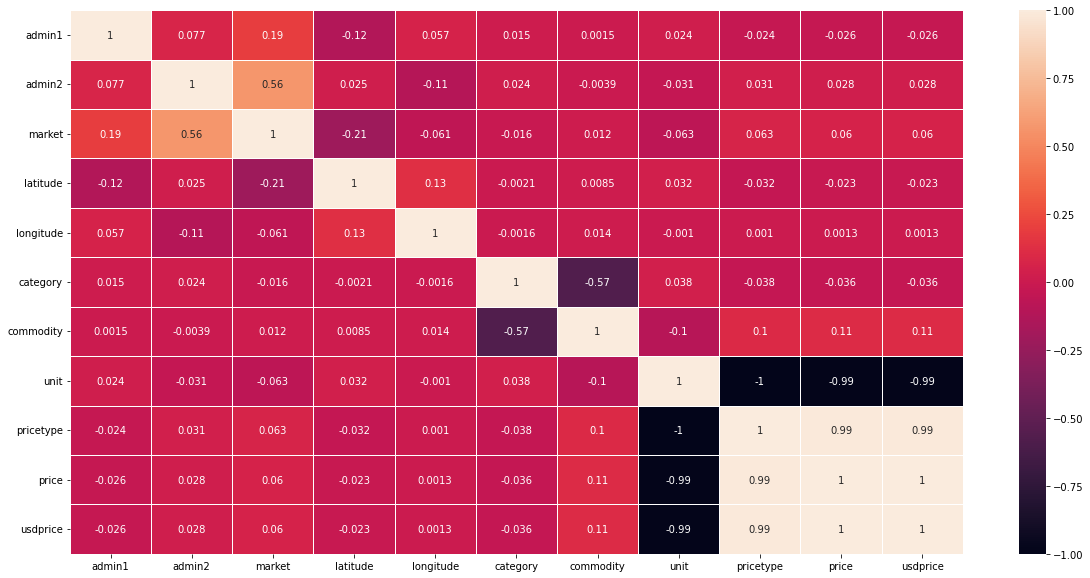

In [19]:
# Graphe de corrélation
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax) #, fmt=".3f"
plt.show()

**pricetype, usdprice, price`** are strongly correlated to each other, so we can keep 1

In [20]:
# Supprimer la colonne 'bus_ter'
df_ner_eq.drop(['pricetype','usdprice'], axis='columns', inplace=True)


In [21]:
df_ner_eq.head()

,admin1,admin2,market,latitude,longitude,category,commodity,unit,price
1,1,41,3,16.973333,7.991111,0,3,1,200.0
4,3,11,23,13.049000,3.193700,0,3,1,200.0
6,4,28,55,13.500000,7.101744,0,3,1,205.0
13,1,41,3,16.973333,7.991111,0,3,1,200.0
16,3,11,23,13.049000,3.193700,0,3,1,200.0
